In [112]:
# Imports and data
import numpy as np
import os
home_path = os.path.expanduser('~')
os.chdir(home_path + '/let-it-flow')
import glob
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

from pytorch3d.ops.knn import knn_points
from loss import sc_utils
from vis.deprecated_vis import *
from ops.visibility3D import *
from loss.flow import DT,FastNN
from torch_scatter import scatter
folder_path = '/mnt/datagrid/public_datasets/let-id-flow/data/argoverse2/sensor/processed_val/'


def sample_argoverse2(seq : int):

    sequence_path = sorted(glob.glob(folder_path + '/*/'))

    file_paths = sorted(glob.glob(sequence_path[seq] + '/*.npz'))

    pc_list = []
    global_list = []
    flow_list = []
    gt_list = []
    compensated_gt_flow_list = []
    dynamic_list = []
    category_indices_list = []
    pose_list = []
    global_pose_list = []
    # mask_list = []
    # mask2_list = []
    


    for t, d_path in enumerate(file_paths):

        data_file = np.load(d_path)

        pc1 = data_file['pc1'][:,:3]
        pc2 = data_file['pc2'][:,:3]
        ground1 = data_file['ground1']
        ground2 = data_file['ground2']
        gt_flow = data_file['flow']
        dynamic = data_file['dynamic']
        category_indices = data_file['category_indices']
        pose = data_file['pose']
        flow_valid = data_file['flow_valid']
        
        max_radius = 35
        max_height = 3
        min_height = 0.0


        mask =(~ground1) & (pc1[..., 2] < max_height) & (pc1[..., 2] > min_height) & (np.linalg.norm(pc1, axis=-1) < max_radius) 
        mask = mask.astype(bool)

        mask2 = (~ground2) & (pc2[..., 2] < max_height) & (pc2[..., 2] > min_height) & (np.linalg.norm(pc2, axis=-1) < max_radius)
        mask2 = mask2.astype(bool)

        pc1 = pc1[mask]
        pc2 = pc2[mask2]
        # pose = torch.tensor(pose)
        # pc2 = pc2[mask2].unsqueeze(0).to(device)

        compensated_pc1 = (pose[:3,:3] @ pc1.T).T + pose[:3, -1][None]


        # compensated GT_flow 
        ego_flow = compensated_pc1 - pc1

        gt_flow = gt_flow[mask] 
        compensated_gt_flow = gt_flow - ego_flow

        

        category_indices = category_indices[mask]
        dynamic = dynamic[mask]
        compensated_pc1 = compensated_pc1

        # cur_pose = first_pose @ np.linalg.inv(pose)


        pc_list.append(pc1)
        flow_list.append(gt_flow)
        compensated_gt_flow_list.append(compensated_gt_flow)
        gt_list.append(gt_flow)
        dynamic_list.append(dynamic)
        category_indices_list.append(category_indices)
        pose_list.append(pose)

    final_poses = []
    
    # construct path from relative poses
    pose = np.eye(4)[None]
    poses = pose.copy()
    for i in range(len(pose_list)):
        pose = pose @ np.linalg.inv(pose_list[i])
        poses = np.concatenate([poses, pose], axis=0)

    for i in range(len(poses) - 1):
        global_pc = (poses[i, :3,:3] @ pc_list[i].T).T + poses[i, :3, -1][None]
        global_pc = np.insert(global_pc, 3, i, axis=-1)
        global_list.append(global_pc)
    
    return global_list, poses, gt_flow, compensated_gt_flow_list, dynamic_list, category_indices_list
    # visualize_multiple_pcls(*global_list)
    # visualize_points3D(poses[...,:3,-1])



# %%timeit -n 10
##### match into lower cluster id
# converged = True

# old_clusters = clusters.copy()
def pass_id_clusters(c1, c2, nn):
    # dist, nn, _ = knn_points(p1 + f1, p2, K=1)

    for clu_id in range(c1.max() + 1):

        # divne, znovu
        # TODO - DISTANCE threshold?
        matched = c2[nn[0,:,0][c1 == clu_id]]
        
        matched_ids = torch.unique(matched)    
        # print(matched_ids)
        
        # TODO - time matching across full sequence?
        # TODO - check it properly

        # match only itself
        if len(matched_ids) == 1 and matched_ids[0] == clu_id:
            continue
        
        matched_ids = matched_ids[matched_ids != -1]

        if len(matched_ids) == 0:
            continue
        

        if clu_id <= torch.min(matched_ids):
            chosen_id = clu_id
        else:
            chosen_id = torch.min(matched_ids)
        

        c1[c1 == clu_id] = chosen_id

        for m_id in matched_ids:    

            c2[c2 == m_id] = chosen_id

    return c1

# 2D

class SC2_KNN_cluster_aware(torch.nn.Module):
    
    ''' Our soft-rigid regularization with neighborhoods
    pc1 : Point cloud
    K : Number of NN for the neighborhood
    use_normals : Whether to use surface estimation for neighborhood construction
    d_thre : constant for working with the displacements as percentual statistics, we use value from https://github.com/ZhiChen902/SC2-PCR
    '''
    def __init__(self, pc1, K=16, d_thre=0.03):
        super().__init__()
        self.d_thre = d_thre
        self.K = K
        dist, self.kNN, _ = knn_points(pc1, pc1, lengths1=None, lengths2=None, K=K, return_nn=True)
    
        
        self.src_keypts = pc1[:, self.kNN[:, :, :]]

    def forward(self, flow, ids=None):

        target_keypts = self.src_keypts + flow[:, self.kNN[:, :, :]]
        target_keypts = target_keypts[0, 0]
        src_keypts = self.src_keypts[0, 0]


        target_keypts = src_keypts + flow[:, self.kNN[:, :, :]][0,0]
        

        src_dist = (src_keypts[:, :, None, :] - src_keypts[:, None, :, :]).norm(dim=-1)
        target_dist = (target_keypts[:, :, None, :] - target_keypts[:, None, :, :]).norm(dim=-1)
        cross_dist = (src_dist - target_dist).abs()
        A = torch.clamp(1.0 - cross_dist ** 2 / self.d_thre ** 2, min=0)
        # self.A = A

        leading_eig = sc_utils.power_iteration(A)
        # 
        # self.leading_eig = leading_eig
        sc2_rigidity = sc_utils.spatial_consistency_score(A, leading_eig)
        loss = - torch.log(sc2_rigidity).mean()

        if ids is not None: 
            self.ids_matrix = ids[self.kNN][0]
            logic_id_matrix = RigidLoss.ids_matrix[:, None, :] == RigidLoss.ids_matrix[:, :,None]
            
            sc_rigidity = cross_dist * logic_id_matrix.float()

            loss += sc_rigidity.mean()

        return loss

def center_rigidity_loss(pc1, flow, cluster_ids):
    '''
    For batch size of 1
    :param pc1: 
    :param flow: 
    :param cluster_ids: 
    :return: 
    '''
    pts_centers = scatter(pc1, cluster_ids, dim=1, reduce='mean')
    flow_centers = scatter(pc1 + flow, cluster_ids, dim=1, reduce='mean')
    
    pt_dist_to_center = (pc1 - pts_centers[0, cluster_ids[0]].unsqueeze(0))#.norm(dim=-1, p=1)
    flow_dist_to_center = ((pc1 + flow) - flow_centers[0, cluster_ids[0]].unsqueeze(0))#.norm(dim=-1, p=1)
    
    center_displacement = pt_dist_to_center - flow_dist_to_center
    
    rigidity_loss = center_displacement.norm(dim=-1).mean()

    return rigidity_loss


def initial_clustering(global_list, frame, temporal_range, device, eps=0.3, min_samples=1, z_scale=0.5):

    # init clustering
    to_cluster_pc1 = np.concatenate(global_list[:temporal_range], axis=0)
    scaled_cluster_pc1 = to_cluster_pc1[:,:3] * (1,1, z_scale)   # scale z-axis
    # Spatio-temporal clustering with fixed temporal range
    clusters = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(scaled_cluster_pc1[:,:3])
    # visualize_points3D(to_cluster_pc1, clusters)

    frame = 2
    p1 = to_cluster_pc1[to_cluster_pc1[:,3] == frame][None, :,:3]
    p2 = to_cluster_pc1[to_cluster_pc1[:,3] == frame + 1][None, :,:3]

    c1 = clusters[to_cluster_pc1[:,3] == frame]
    c2 = clusters[to_cluster_pc1[:,3] == frame + 1]


    
    f1 = torch.zeros(p1.shape, device=device, requires_grad=True)
    p1 = torch.tensor(p1, device=device, dtype=torch.float32)
    p2 = torch.tensor(p2, device=device, dtype=torch.float32)
    c1 = torch.tensor(c1, device=device)    # clusters are without batch dim
    c2 = torch.tensor(c2, device=device)

    return p1, p2, c1, c2, f1   # points, ids, flow initialed to 0


def calculate_polar_coords(pc : torch.tensor):
    assert len(pc.shape) == 2

    calc_depth = pc.norm(dim=-1)
    yaw = - torch.arctan2(pc[:, 1], pc[:, 0])
    pitch = torch.arcsin(pc[:, 2] / (calc_depth + 1e-8))

    return yaw, pitch, calc_depth

def compute_freespace_mask(p1, f1, p2):
    # Constants
    p2_yaw, p2_pitch, p2_depth = calculate_polar_coords(p2[0])
    flow_yaw, flow_pitch, flow_depth = calculate_polar_coords((p1+f1)[0])

    polar_p2 = torch.stack((p2_yaw, p2_pitch, p2_depth), dim=-1)
    polar_flow = torch.stack((flow_yaw, flow_pitch, flow_depth), dim=-1)
    polar_angle_diff, polar_nn, _ = knn_points(polar_flow[None, :, :2], polar_p2[None, :, :2], K=1, return_nn=True)


    depth_diff = p2_depth[polar_nn[0,:,0]] - flow_depth

    pts_in_freespace = (depth_diff > 0.05) & (depth_diff < 0.3) & (polar_angle_diff[0,:,0].abs() < 0.01)    # HYPERPARAMS
    # print(pts_in_freespace.sum())
    # use it as weights
    return pts_in_freespace

    # visualize_multiple_pcls(*[p1[0], (p1+f1)[0, pts_in_freespace], p2[0]] )


use_gpu = 3 # int(sys.argv[1])
device = torch.device(f'cuda:{use_gpu}')

available_gpus = 4

Argoverse2_seqs = 150
seq_arrays = np.array_split(range(Argoverse2_seqs), available_gpus)

for seq_id in seq_arrays[use_gpu]:

    global_list, poses, gt_flow, compensated_gt_flow_list, dynamic_list, category_indices_list = sample_argoverse2(seq_id)

    # 150 sequences

    

    store_path = f'{os.path.expanduser("~")}/data/exps/argoverse2/seq_{seq_id}/'
    os.makedirs(store_path, exist_ok=True)

    cfg = {'frame' : 2,
    'dist_w' : 2.,
    'free_w' : 0.5,
    'TEMPORAL_RANGE' : 5,
    'sc_w' : 1.,
    'lr' : 0.03,
    'trunc_dist' : 0.5,
    'passing_ids' : True,
    'K' : 16,
    'd_thre' : 0.03,
    'eps' : 0.3,
    'min_samples' : 1,
    }

    frame = 2
    # Hyperparams
    dist_w = 2.
    free_w = 0.5
    TEMPORAL_RANGE = 5
    sc_w = 1.
    trunc_dist = 0.5
    passing_ids = True
    K = 16
    d_thre = 0.03
    eps = 0.3
    min_samples = 1
    lr = cfg['lr']

    p1, p2, c1, c2, f1 = initial_clustering(global_list, frame, TEMPORAL_RANGE, device, eps=eps, min_samples=min_samples, z_scale=0.5)

    # print(p1.shape, p2.shape, f1.shape)
    optimizer = torch.optim.Adam([f1], lr=lr)

    RigidLoss = SC2_KNN_cluster_aware(p1, K=K, d_thre=d_thre)
    # todo mask out knn in sc2
    for it in tqdm(range(20)):    # really need to converge here
        loss = 0

        # todo reindex clusters
        
        # _, dist = distance_transform.torch_bilinear_distance(p1 + f1)
        # _, dist_b = distance_transform_backward.torch_bilinear_distance(p2)

        dist, nn, _ = knn_points(p1 + f1, p2, lengths1=None, lengths2=None, K=1, return_nn=True)    # fast flow speedup? - precision?
        dist_b, nn_b, _ = knn_points(p2, p1 + f1, lengths1=None, lengths2=None, K=1, return_nn=True)    # fast flow speedup?
        loss += dist_w * (dist[dist < trunc_dist].mean() + dist_b[dist_b < trunc_dist].mean())

        # Freespace
        if free_w > 0:
            freespace_mask = compute_freespace_mask(p1, f1, p2)
            loss += free_w * dist[0, freespace_mask, 0][dist[0, freespace_mask, 0] < trunc_dist].mean()   # f weights

        sc_loss = RigidLoss(f1, c1)
        
        if sc_w > 0:
            loss += sc_w * sc_loss
            loss += sc_w * center_rigidity_loss(p1, f1, c1[None] + 1)    # + 1 for noise, works!

        loss += f1[..., 2].norm().mean()
        

        if it % 10 == 0 and passing_ids:
            c1 = pass_id_clusters(c1, c2, nn)

        loss.backward()

        
        optimizer.step()
        optimizer.zero_grad()

    # store flow
    store_dict = {'p1' : p1.detach().cpu().numpy(), 'p2' : p2.detach().cpu().numpy(),
                   'c1' : c1.detach().cpu().numpy(), 'f1' : f1.detach().cpu().numpy(),
                   'gt_flow' : gt_flow[frame], 'compensated_gt_flow' : compensated_gt_flow_list[frame], 'dynamic' : dynamic_list[frame],
                     'category_indices' : category_indices_list[frame]}
    np.savez(store_path + f'/{frame:06d}.npz', **store_dict)

    # visualize_flow3d(p1[0].cpu().numpy(), p2[0].cpu().numpy(), f1[0].detach().cpu().numpy())


100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.19it/s]


KeyboardInterrupt: 

# Metric

In [104]:
BACKGROUND_CATEGORIES = ["BACKGROUND"]

# These catagories are ignored because of labeling oddities (moving stop signs on side of school bus, etc)
ROAD_SIGNS = [
    "BOLLARD",
    "CONSTRUCTION_BARREL",
    "CONSTRUCTION_CONE",
    "MOBILE_PEDESTRIAN_CROSSING_SIGN",
    "SIGN",
    "STOP_SIGN",
    "MESSAGE_BOARD_TRAILER",
    "TRAFFIC_LIGHT_TRAILER",
]

PEDESTRIAN_CATEGORIES = ["PEDESTRIAN", "STROLLER", "WHEELCHAIR", "OFFICIAL_SIGNALER"]

WHEELED_VRU = [
    "BICYCLE",
    "BICYCLIST",
    "MOTORCYCLE",
    "MOTORCYCLIST",
    "WHEELED_DEVICE",
    "WHEELED_RIDER",
]

CAR = ["REGULAR_VEHICLE"]

OTHER_VEHICLES = [
    "BOX_TRUCK",
    "LARGE_VEHICLE",
    "RAILED_VEHICLE",
    "TRUCK",
    "TRUCK_CAB",
    "VEHICULAR_TRAILER",
    "ARTICULATED_BUS",
    "BUS",
    "SCHOOL_BUS",
]

BUCKETED_METACATAGORIES = {
    "BACKGROUND": BACKGROUND_CATEGORIES,
    "CAR": CAR,
    "PEDESTRIAN": PEDESTRIAN_CATEGORIES,
    "WHEELED_VRU": WHEELED_VRU,
    "OTHER_VEHICLES": OTHER_VEHICLES,
}

THREEWAY_EPE_METACATAGORIES = {
    "BACKGROUND": BACKGROUND_CATEGORIES,
    "FOREGROUND": PEDESTRIAN_CATEGORIES + WHEELED_VRU + CAR + OTHER_VEHICLES,
}

# Dummy remap
class_remap = {0 : 'Background',
               5 : 'Road Sign?',
               6 : 'Truck',
               11 : "Van",
               15 : 'Cyclist',
               17 : 'Pedestrian',
               19 : 'Vehicle',
               21 : 'Sign?',
               28 : 'IDK'}

# visualize_points3D(p1[0], category_indices)
# print(data_file.files)
# eval_flow = flow[0].detach().cpu().numpy()
eval_flow = f1[0].detach().cpu().numpy()
dynamic = dynamic_list[frame]
category_indices = category_indices_list[frame]
compensated_gt_flow = compensated_gt_flow_list[frame]
for idx in np.unique(category_indices):
    class_mask = category_indices == idx
    
    class_name = class_remap[idx]
    
    # class_name = 'unknown'
    print(f'IDX: {idx}')
    print(f'Class {class_name} EPE: {np.linalg.norm(compensated_gt_flow[class_mask] - eval_flow[class_mask], axis=-1).mean():.3f}')
    print(f'Class {class_name} Dynamic EPE: {np.linalg.norm(compensated_gt_flow[class_mask & dynamic] - eval_flow[class_mask & dynamic], axis=-1).mean():.3f}')
    print(f'Class {class_name} Static EPE: {np.linalg.norm(compensated_gt_flow[class_mask & ~dynamic] - eval_flow[class_mask & ~dynamic], axis=-1).mean():.3f}')
    

# visualize_points3D(p1[0], category_indices)
# visualize_points3D(p1[0], np.linalg.norm(eval_flow, axis=-1))
# visualize_points3D(p1[0], np.linalg.norm(c=======ompensated_gt_flow, axis=-1))
# visualize_flow3d(p1[0], p2[0], compensated_gt_flow)
# visualize_flow3d(p1[0], p2[0], eval_flow)

IDX: 0
Class Background EPE: 0.049
Class Background Dynamic EPE: nan
Class Background Static EPE: 0.049
IDX: 6
Class Truck EPE: 0.028
Class Truck Dynamic EPE: nan
Class Truck Static EPE: 0.028
IDX: 11
Class Van EPE: 0.019
Class Van Dynamic EPE: nan
Class Van Static EPE: 0.019
IDX: 17
Class Pedestrian EPE: 0.047
Class Pedestrian Dynamic EPE: 0.045
Class Pedestrian Static EPE: 0.062
IDX: 19
Class Vehicle EPE: 0.036
Class Vehicle Dynamic EPE: 0.065
Class Vehicle Static EPE: 0.035


/tmp/ipykernel_2777155/883821303.py:79: RuntimeWarning: Mean of empty slice.
  print(f'Class {class_name} Dynamic EPE: {np.linalg.norm(compensated_gt_flow[class_mask & dynamic] - eval_flow[class_mask & dynamic], axis=-1).mean():.3f}')


# CPU registration

In [7]:
# # NUMPY VERSION - DO NOT DELETE!
# import open3d as o3d

# # recompute results with this, visibility later during iterations?
# # init?
# # What about the noise?
# for idx in range(c1.max() + 1):
    
#     # object_mask = c1 == idx
#     obj_pts = p1[c1 == idx, :3]
#     # obj_pts_list = [obj_pts[obj_pts[:,-1] == t][:,:3] for t in range(TEMPORAL_RANGE)]

#     obj2_pts = p2[c2 == idx, :3]
    
#     # mean
#     source = o3d.geometry.PointCloud()
#     source.points = o3d.utility.Vector3dVector(obj_pts)
    

#     target = o3d.geometry.PointCloud()
#     target.points = o3d.utility.Vector3dVector(obj2_pts)   # compute to
    
#     threshold = 0.4 # should be same parameter as spatio-temporal clustering?
#     trans_init = np.eye(4)  # reinit?
    
#     icp_reg = o3d.pipelines.registration.registration_icp(source, target, threshold, trans_init,
#                                                         o3d.pipelines.registration.TransformationEstimationPointToPoint(),
#                                                         o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))

#     # savgol filter
#     trans = icp_reg.transformation
#     # vis
#     global_pts = (trans[:3,:3] @ obj_pts.T).T + trans[:3,-1]

#     object_flow = global_pts - obj_pts

#     f1[c1 == idx] = object_flow    
#     f1[c1 == idx, 2] = 0  # do it?
    
# ##### match into lower cluster id
# converged = True

# old_clusters = clusters.copy()
# # while converged:
# from sklearn.neighbors import NearestNeighbors

# def knn(X, Y, K=1):
#     dist, nn, = NearestNeighbors(n_neighbors=K).fit(Y).kneighbors(X)
#     return dist, nn

# dist, nn = knn(p1 + f1, p2, K=1)

# for clu_id in range(c1.max() + 1):

#     # divne, znovu
#     # TODO - DISTANCE threshold?
#     matched = c2[nn[c1 == clu_id]]
    
#     matched_ids = np.unique(matched)    
#     # print(matched_ids)
    
#     # TODO - time matching across full sequence?
#     # TODO - check it properly

#     # match only itself
#     if len(matched_ids) == 1 and matched_ids[0] == clu_id:
#         continue
    
#     matched_ids = matched_ids[matched_ids != -1]

#     if len(matched_ids) == 0:
#         continue
    

#     if clu_id <= np.min(matched_ids):
#         chosen_id = clu_id
#     else:
#         chosen_id = np.min(matched_ids)
    

#     c1[c1 == clu_id] = chosen_id

#     for m_id in matched_ids:    

#         c2[c2 == m_id] = chosen_id


# # if len(matched_ids) > 0:
# #     break

# # print(clu_id, labels.max())
# # if clu_id == labels.max():
# # break

# # instance with car does not match properly
# # already some changes!        
# visualize_points3D(p1, c1, bg_color=(0.7,0.7,0.7,0.7), show_grid=False)
# # visualize_points3D(pc1.view(-1,3).detach().cpu().numpy(), pc1[..., -1].view(-1).detach().cpu().numpy())

# Metric

In [40]:
BACKGROUND_CATEGORIES = ["BACKGROUND"]

# These catagories are ignored because of labeling oddities (moving stop signs on side of school bus, etc)
ROAD_SIGNS = [
    "BOLLARD",
    "CONSTRUCTION_BARREL",
    "CONSTRUCTION_CONE",
    "MOBILE_PEDESTRIAN_CROSSING_SIGN",
    "SIGN",
    "STOP_SIGN",
    "MESSAGE_BOARD_TRAILER",
    "TRAFFIC_LIGHT_TRAILER",
]

PEDESTRIAN_CATEGORIES = ["PEDESTRIAN", "STROLLER", "WHEELCHAIR", "OFFICIAL_SIGNALER"]

WHEELED_VRU = [
    "BICYCLE",
    "BICYCLIST",
    "MOTORCYCLE",
    "MOTORCYCLIST",
    "WHEELED_DEVICE",
    "WHEELED_RIDER",
]

CAR = ["REGULAR_VEHICLE"]

OTHER_VEHICLES = [
    "BOX_TRUCK",
    "LARGE_VEHICLE",
    "RAILED_VEHICLE",
    "TRUCK",
    "TRUCK_CAB",
    "VEHICULAR_TRAILER",
    "ARTICULATED_BUS",
    "BUS",
    "SCHOOL_BUS",
]

BUCKETED_METACATAGORIES = {
    "BACKGROUND": BACKGROUND_CATEGORIES,
    "CAR": CAR,
    "PEDESTRIAN": PEDESTRIAN_CATEGORIES,
    "WHEELED_VRU": WHEELED_VRU,
    "OTHER_VEHICLES": OTHER_VEHICLES,
}

THREEWAY_EPE_METACATAGORIES = {
    "BACKGROUND": BACKGROUND_CATEGORIES,
    "FOREGROUND": PEDESTRIAN_CATEGORIES + WHEELED_VRU + CAR + OTHER_VEHICLES,
}

# Dummy remap
class_remap = {0 : 'Background',
               5 : 'Road Sign?',
               6 : 'Truck',
            #    11 : "Van",
               15 : 'Cyclist',
               17 : 'Pedestrian',
               19 : 'Vehicle',
            #    21 : 'Sign?',
               28 : 'IDK'}


import numpy as np
import os
os.chdir(f'{os.path.expanduser("~")}/let-it-flow/')
import glob
import torch
import pandas as pd
from ops.metric import SceneFlowMetric, ThreewayFlowMetric

for model in sorted(os.listdir(f'{os.path.expanduser("~")}/data/exps/argoverse2')):
    if not model.startswith('ours') : continue
# for model in ['w_freespace', 'without_free', 'chodosh', 'NP']:
    # print('\n', model.capitalize())

    exp_folder = f'{os.path.expanduser("~")}/data/exps/argoverse2/{model}/'
    files = sorted(glob.glob(exp_folder + '/*/*.npz'))

    ThreewayMetric = ThreewayFlowMetric()
    PedsFlowMetric = ThreewayFlowMetric()
    VehsFlowMetric =  ThreewayFlowMetric()
    CycFlowMetric =  ThreewayFlowMetric()
    TruckFlowMetric =  ThreewayFlowMetric()

    for file in files:
        data = np.load(file, allow_pickle=True)

        p1 = data['p1']
        p2 = data['p2']
        f1 = torch.from_numpy(data['f1'])
        dynamic = torch.from_numpy(data['dynamic'])
        category_indices = torch.from_numpy(data['category_indices'])
        gt_flow = torch.from_numpy(data['compensated_gt_flow'][None])  # correct

        map_dict = {'foreground_cls' : [6, 19, 17, 15], # bicyclist vs bicycle
                    'background_cls' : [0],
                    }
        
        # pred_flow, gt_flow, eval_time, dynamic_foreground_mask, static_foreground_mask, static_background_mask
        foreground = (category_indices == 6) | (category_indices == 19) | (category_indices == 17) | (category_indices == 15)
        
        dynamic_foreground_mask = dynamic & foreground
        static_foreground_mask = ~dynamic & foreground
        static_background_mask = ~dynamic & category_indices == 0

        # print(gt_flow.shape, f1.shape)
        ThreewayMetric.update(f1, gt_flow, -1, dynamic_foreground_mask, static_foreground_mask, static_background_mask)

        # peds
        peds_mask = (category_indices == 17)
        dynamic_foreground_mask = dynamic & peds_mask
        static_foreground_mask = ~dynamic & peds_mask
        static_background_mask = torch.zeros_like(dynamic, dtype=bool)

        PedsFlowMetric.update(f1, gt_flow, -1, dynamic_foreground_mask, static_foreground_mask, static_background_mask)

        # vehs
        vehs_mask = (category_indices == 19)
        dynamic_foreground_mask = dynamic & vehs_mask
        static_foreground_mask = ~dynamic & vehs_mask
        static_background_mask = torch.zeros_like(dynamic, dtype=bool)

        VehsFlowMetric.update(f1, gt_flow, -1, dynamic_foreground_mask, static_foreground_mask, static_background_mask)

        # cycs
        cycs_mask = (category_indices == 15)
        dynamic_foreground_mask = dynamic & cycs_mask
        static_foreground_mask = ~dynamic & cycs_mask
        static_background_mask = torch.zeros_like(dynamic, dtype=bool)

        CycFlowMetric.update(f1, gt_flow, -1, dynamic_foreground_mask, static_foreground_mask, static_background_mask)

        # trucks
        trucks_mask = (category_indices == 6)
        dynamic_foreground_mask = dynamic & trucks_mask
        static_foreground_mask = ~dynamic & trucks_mask
        static_background_mask = torch.zeros_like(dynamic, dtype=bool)

        TruckFlowMetric.update(f1, gt_flow, -1, dynamic_foreground_mask, static_foreground_mask, static_background_mask)

    T_D = ThreewayMetric.DFG_metric.get_metric().mean()['EPE']
    T_S = ThreewayMetric.SFG_metric.get_metric().mean()['EPE']
    T_B = ThreewayMetric.SBG_metric.get_metric().mean()['EPE']
    
    # break
    Average = (T_D + T_S + T_B) / 3
    
    print(model.upper())

    print('Threeway',  f"{Average:.3f}", f'{T_D:.3f}', f'{T_S:.3f}', f'{T_B:.3f}')
    
    # print("THREEWAY METRIC ------")
    # ThreewayMetric.print_metric()

    # print('\n\n\n')
    # print("PEDS METRIC ---------")

    # T_D = PedsFlowMetric.DFG_metric.get_metric().mean()['EPE']
    # T_S = PedsFlowMetric.SFG_metric.get_metric().mean()['EPE']
    # # T_B = PedsFlowMetric.SBG_metric.get_metric().mean()['EPE']
    
    # Average = (T_D + T_S) / 2   # there is no background for dynamic class
    
    # print( 'Peds', f"{Average:.3f}",  "&",f'{T_D:.3f}', "&", f'{T_S:.3f}', end=' ')
    # # PedsFlowMetric.print_metric()
    

    # # print('\n\n\n')
    # # print("CYCS METRIC ---------")
    # T_D = CycFlowMetric.DFG_metric.get_metric().mean()['EPE']
    # T_S = CycFlowMetric.SFG_metric.get_metric().mean()['EPE']
    # # T_B = PedsFlowMetric.SBG_metric.get_metric().mean()['EPE']
    
    # Average = (T_D + T_S) / 2   # there is no background for dynamic class
    
    # print( 'Cycs', f"{Average:.3f}",  "&", f'{T_D:.3f}',  "&", f'{T_S:.3f}', end=' ')

    # # print('\n\n\n')
    # # print("VEHS METRIC ---------")
    # T_D = VehsFlowMetric.DFG_metric.get_metric().mean()['EPE']
    # T_S = VehsFlowMetric.SFG_metric.get_metric().mean()['EPE']
    # # T_B = PedsFlowMetric.SBG_metric.get_metric().mean()['EPE']
    
    # Average = (T_D + T_S) / 2   # there is no background for dynamic class
    
    # print( 'Vehs', f"{Average:.3f}", "&", f'{T_D:.3f}',  "&", f'{T_S:.3f}', end=' ')
    # # VehsFlowMetric.print_metric()
    
    
    # # CycFlowMetric.print_metric()
    
    # # print('\n\n\n')
    # # print("TRUCKS METRIC ---------")
    # T_D = TruckFlowMetric.DFG_metric.get_metric().mean()['EPE']
    # T_S = TruckFlowMetric.SFG_metric.get_metric().mean()['EPE']
    # T_B = PedsFlowMetric.SBG_metric.get_metric().mean()['EPE']
    
    # Average = (T_D + T_S) / 2   # there is no background for dynamic class
    
    # # print('Truck', f"{Average:.3f}",  "&",f'{T_D:.3f}',  "&",f'{T_S:.3f}')
    # # TruckFlowMetric.print_metric()
    print('\n------\n')




OURS-WITHOUT_SCKNN
Threeway 0.052 0.089 0.040 0.028

------

OURS-WITHOUT_FREESPACE
Threeway 0.047 0.079 0.035 0.026

------

OURS-WITHOUT_PASSING_IDS
Threeway 0.046 0.077 0.035 0.025

------

OURS-WITHOUT_RIGIDITY
Threeway 0.244 0.504 0.103 0.124

------



Visuals

In [2]:

# visualize_points3D(p1[0], category_indices)
# mask = category_indices == 17
# ThreewayMetric.DFG_metric.get_metric().mean()
# visualize_flow3d(p1[0, mask], p2[0], f1[0, mask])
# visualize_flow3d(p1[0], p2[0], f1[0])

ModuleNotFoundError: No module named 'vis'

/tmp/ipykernel_3012106/3390681995.py:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


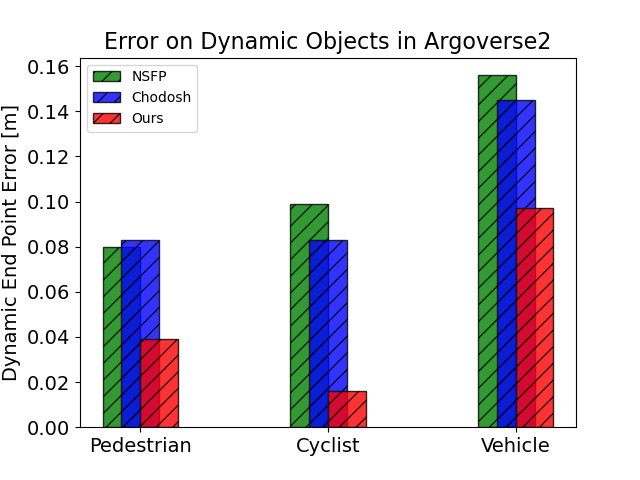

In [44]:
import os
# os.chdir(f'{os.path.expanduser("~")}/let-it-flow/')
# from vis.deprecated_vis import *
import numpy as np
import os
# from vis.deprecated_vis import *
import numpy as np
import matplotlib.pyplot as plt

# Assuming we have data in two lists:
plt.clf()
plt.close()
categories = ['Category1', 'Category2', 'Category3']
values = [10, 20, 30]

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar plot example')
plt.show()
# Assuming we have data in three lists:
categories = ['Pedestrian', 'Cyclist', 'Vehicle']
values1 = [0.080, 0.099, 0.156] # nsfp
values2 = [0.083, 0.083, 0.145] # chodosh
values3 = [0.039, 0.016, 0.097] # ours

# Create an array with the positions of each bar along the x-axis
x = np.arange(len(categories))

# Set the width of the bars
bar_width = 0.2

# Create the bars
plt.bar(x - bar_width / 2 , values1, width=bar_width, label='NSFP', color='g', edgecolor='black', hatch='//', alpha=0.8)
plt.bar(x, values2, width=bar_width, label='Chodosh', color='b',edgecolor='black', hatch='//', alpha=0.8)
plt.bar(x + bar_width / 2 , values3, width=bar_width, label='Ours', color='red', edgecolor='black', hatch='//', alpha=0.8)

# Add labels and title
plt.xlabel('')
plt.ylabel('Dynamic End Point Error [m]', fontsize=14)
plt.title('Error on Dynamic Objects in Argoverse2', fontsize=16)

# Add xticks on the middle of the group bars
plt.xticks(x, categories)

plt.tick_params(axis='both', which='major', labelsize=14)

# Create legend & Show graphic
plt.legend()
plt.savefig('dynamic_performance.png', dpi=500)
# imshow(plt)


